In [72]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import cv2
from scipy.stats import spearmanr
import torch

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anasmohammedtahir/covidqu")

print("Path to dataset files:", path)

/Users/antoinemaechler/towards-evaluating-explanations-of-vit/explainenv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/antoinemaechler/.cache/kagglehub/datasets/anasmohammedtahir/covidqu/versions/7


In [41]:
import os
from PIL import Image

# Path to your images folder
image_folder = "anasmohammedtahir/covidqu/versions/7/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/images"
masks_folder = "anasmohammedtahir/covidqu/versions/7/Lung Segmentation Data/Lung Segmentation Data/Test/COVID-19/lung masks"

# List all image filenames in the folder
image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(".png")])
masks_files = sorted([os.path.join(masks_folder, f) for f in os.listdir(masks_folder) if f.endswith(".png")])

# Load all images into a list
data = [np.array(Image.open(img))/255.0 for img in image_files]
data_masks = [np.array(Image.open(img))/255.0 for img in masks_files]


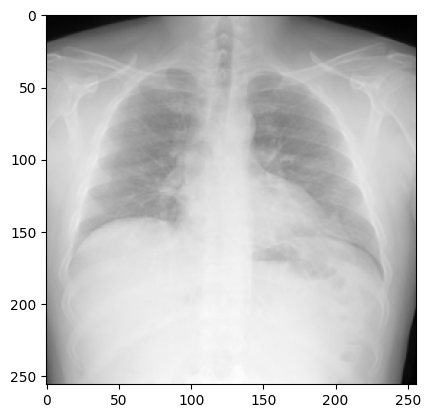

In [42]:
plt.imshow(data[0], cmap="gray")

In [16]:
def faithfulness_correlation(model, data, heatmaps, removal_ratio=0.1):
    """
    Compute the faithfulness correlation between the model's prediction and the heatmap.
    The function removes the most important features in the heatmap and observes the effect on predictions.
    
    Args:
        model: The deep learning model.
        data (numpy array): Batch of input images (N, C, H, W).
        heatmaps (numpy array): Corresponding heatmaps (N, 1, H, W).
        removal_ratio (float): Fraction of top pixels to remove.
    
    Returns:
        float: Spearman correlation between logit changes and heatmap importance.
    """
    model.eval()
    
    original_logits = model(torch.tensor(data, dtype=torch.float32)).detach().numpy()
    
    perturbed_data = data.copy()
    
    for i in range(len(data)):
        heatmap = heatmaps[i, 0]  # Single-channel heatmap
        threshold = np.percentile(heatmap, 100 * (1 - removal_ratio))
        mask = heatmap >= threshold  # Mask for important regions
        perturbed_data[i][:, mask] = 0  # Remove important features
    
    perturbed_logits = model(torch.tensor(perturbed_data, dtype=torch.float32)).detach().numpy()
    
    logit_differences = original_logits - perturbed_logits
    heatmap_importance = heatmaps.mean(axis=(2, 3))  # Average importance per sample
    
    return spearmanr(logit_differences.flatten(), heatmap_importance.flatten()).correlation

In [18]:
def average_sensitivity(model, data, heatmaps, num_samples=10, noise_std=0.02):
    """
    Compute the average sensitivity of explanations under small perturbations.
    
    Args:
        model: The deep learning model.
        data (numpy array): Batch of input images (N, C, H, W).
        heatmaps (numpy array): Corresponding heatmaps (N, 1, H, W).
        num_samples (int): Number of perturbed samples per input.
        noise_std (float): Standard deviation of noise added to inputs.
    
    Returns:
        float: Average sensitivity across all samples.
    """
    model.eval()
    
    total_sensitivity = 0
    for i in range(len(data)):
        original_explanation = heatmaps[i]
        sensitivity_per_sample = []
        
        for _ in range(num_samples):
            perturbed_input = data[i] + np.random.normal(0, noise_std, data[i].shape)
            perturbed_input = np.clip(perturbed_input, 0, 1)
            
            perturbed_explanation = generate_heatmap(model, perturbed_input)  # Function to generate heatmap
            
            diff = np.abs(original_explanation - perturbed_explanation).mean()
            sensitivity_per_sample.append(diff)
        
        total_sensitivity += np.mean(sensitivity_per_sample)
    
    return total_sensitivity / len(data)

In [70]:
def effective_complexity(heatmaps, threshold=0.5):
    """
    Compute effective complexity by counting the number of pixels in the heatmap above a threshold.
    
    Args:
        heatmaps (numpy array): Heatmaps of shape (N, 1, H, W).
        threshold (float): Pixel importance threshold (0-1 scale).
    
    Returns:
        float: Average percentage of important pixels per sample.
    """
    binary_maps = (heatmaps > threshold).astype(np.float32)
    complexity_scores = binary_maps.mean()  # Average per sample
    return np.mean(complexity_scores)

In [71]:
effective_complexity(data_masks[0])

0.19847107

In [25]:
def threshold_heatmap(heatmap, threshold=0.5):
    """
    Apply a threshold to the heatmap to keep only important pixels.
    
    Args:
        heatmap (numpy array): Heatmap of shape (1, H, W).
        threshold (float): Pixel importance threshold (0-1 scale).
    
    Returns:
        numpy array: Binary mask of shape (1, H, W).
    """
    return (np.array(heatmap) >= threshold).astype(np.float32)


In [66]:
def score_on_target(heatmap, mask, threshold=0.5):
    """
    Compute the naive score of the heatmap by comparing it with a binary mask.
    
    Args:
        heatmap (numpy array): Heatmap of shape (1, H, W).
        mask (numpy array): Binary mask of shape (1, H, W).
    
    Returns:
        float: Intersection over Union (IoU) score.
    """
    thresholded_heatmap = threshold_heatmap(heatmap, threshold=threshold)
    
    intersection = (thresholded_heatmap * mask).sum()
    union = mask.sum()
    
    return intersection / union

In [67]:
score_on_target(data[0], data_masks[0])

0.9977704313062197

In [68]:
def score_off_target(heatmap, mask, threshold=0.5):
    """
    Compute the off-target score of the heatmap by comparing it with a binary mask.
    
    Args:
        heatmap (numpy array): Heatmap of shape (1, H, W).
        mask (numpy array): Binary mask of shape (1, H, W).
    
    Returns:
        float: Intersection over Union (IoU) score.
    """
    thresholded_heatmap = threshold_heatmap(heatmap, threshold=threshold)
    
    intersection = (thresholded_heatmap * (1 - mask)).sum()
    union = (1 - mask).sum()
    
    return intersection / union

In [69]:
score_off_target(data[0], data_masks[0])

0.9042624074320851

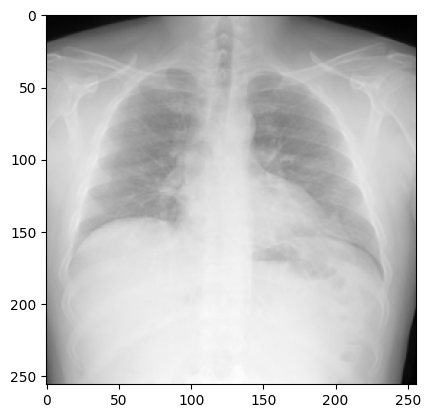

In [56]:
plt.imshow(data[0], cmap='gray')

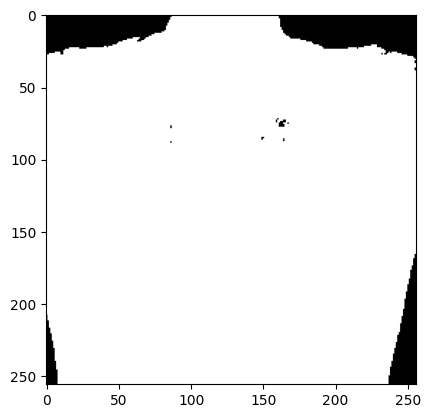

In [58]:
plt.imshow(threshold_heatmap(data[0], threshold=0.5), cmap='gray')